## convert a tensorflow model to a tflite model

#### relevant colab notebook: https://colab.research.google.com/github/frogermcs/TFLite-Tester/blob/master/notebooks/Testing_TFLite_model.ipynb#scrollTo=nOJZlacLG5e7 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [2]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [3]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.9.1
Hub version:  0.12.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [4]:
data_root = 'data/Animals/'

In [5]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 32 images belonging to 5 classes.
Found 138 images belonging to 5 classes.


In [6]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [7]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cheetah' 'Jaguar' 'Leopard' 'Lion' 'Tiger']


In [8]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [10]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20
5/5 [==============================] - 8s 766ms/step - loss: 1.8102 - acc: 0.2899 - val_loss: 1.3256 - val_acc: 0.5000
Epoch 2/20
5/5 [==============================] - 3s 536ms/step - loss: 1.4179 - acc: 0.4638 - val_loss: 1.0201 - val_acc: 0.5938
Epoch 3/20
5/5 [==============================] - 2s 469ms/step - loss: 0.9949 - acc: 0.6594 - val_loss: 0.8142 - val_acc: 0.7500
Epoch 4/20
5/5 [==============================] - 2s 485ms/step - loss: 0.8964 - acc: 0.6522 - val_loss: 0.6789 - val_acc: 0.8438
Epoch 5/20
5/5 [==============================] - 3s 517ms/step - loss: 0.6936 - acc: 0.7754 - val_loss: 0.5993 - val_acc: 0.8125
Epoch 6/20
5/5 [==============================] - 3s 504ms/step - loss: 0.5892 - acc: 0.8043 - val_loss: 0.5469 - val_acc: 0.8125
Epoch 7/20
5/5 [==============================] - 2s 539ms/step - loss: 0.5642 - acc: 0.7899 - val_loss: 0.5021 - val_acc: 0.9062
Epoch 8/20
5/5 [==============================] - 3s 495ms/step - loss: 0.5409 - acc: 0.80

In [11]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

1/1 [==============================] - 1s 599ms/step - loss: 0.3667 - acc: 0.8125


In [12]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.37
Final accuracy: 81.25%


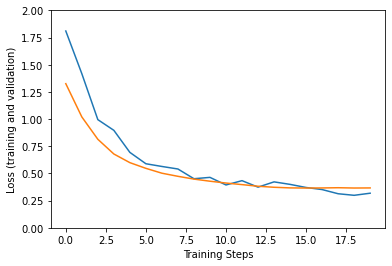

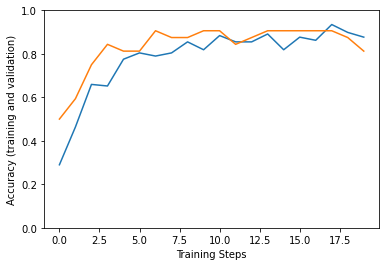

In [13]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [31]:
WILDLIFE_SAVED_MODEL = "saved_models/wildlife"
tf.saved_model.save(model, WILDLIFE_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/wildlife\assets


INFO:tensorflow:Assets written to: saved_models/wildlife\assets


In [32]:
# Load SavedModel

wildlife_model = hub.load(WILDLIFE_SAVED_MODEL)
print(wildlife_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001C544AB6D30>


In [33]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [34]:
tf_model_predictions = wildlife_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [35]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cheetah,Jaguar,Leopard,Lion,Tiger
0,0.00051934,0.00481157,0.00135292,0.00097387,0.99234229
1,0.00568434,0.02246034,0.01010630,0.00648457,0.95526445
2,0.81181186,0.01713197,0.04729570,0.11643936,0.00732111
3,0.00058898,0.00331620,0.00117196,0.00104312,0.99387968
4,0.64893472,0.30901971,0.04189637,0.00004512,0.00010401


In [36]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

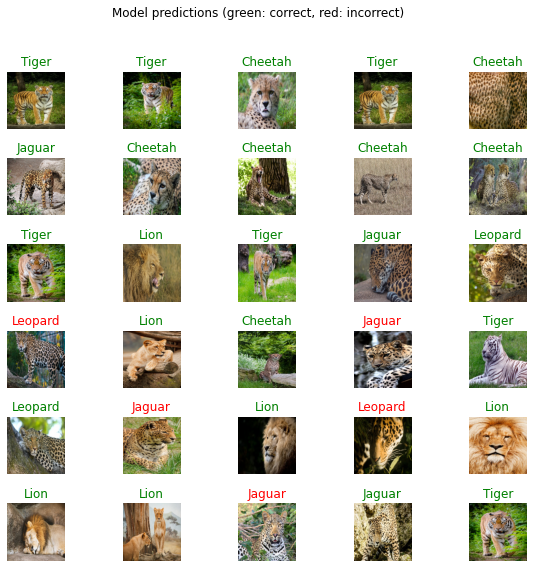

In [37]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [38]:
!mkdir "tflite_models"

In [39]:
TFLITE_MODEL = "tflite_models/wildlife.tflite"
TFLITE_QUANT_MODEL = "tflite_models/wildlife_quant.tflite"

#### keeping the below cell if the error needs to be examined later. the code directly copied from the colab notebook doesnt work, probably because it used tensorflow==2.0, while we use tensorflow~2.9

In [28]:

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : wildlife_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func], trackable_obj=None)
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func], trackable_obj=None)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

ConverterError: <unknown>:0: error: loc(fused["Conv2D:", "predict/MobilenetV2/Conv/Conv2D", "StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D"]): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["Conv2D:", "predict/MobilenetV2/Conv/Conv2D", "StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D"]): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: Conv2D
Details:
	tf.Conv2D(tensor<?x?x?x?xf32>, tensor<3x3x3x32xf32>) -> (tensor<?x?x?x32xf32>) : {data_format = "NHWC", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "SAME", strides = [1, 2, 2, 1], use_cudnn_on_gpu = true}



#### logic below same as above, with some modifications to get it to work 

In [42]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : wildlife_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# MODIFIED CODE - essentially, we're saving from a 'saved model' rather than a concrete function
# Convert the model
saved_model_dir = 'saved_models/wildlife'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!dir "tflite_models" 

TFLite models and their sizes:
 Volume in drive C is Windows
 Volume Serial Number is 6652-A1ED

 Directory of C:\Users\amoel.geogy\Documents\ml_misc\tflite_models

06/27/2022  03:33 PM    <DIR>          .
06/27/2022  03:31 PM    <DIR>          ..
06/27/2022  03:32 PM         8,916,052 wildlife.tflite
06/27/2022  03:33 PM         2,538,976 wildlife_quant.tflite
               2 File(s)     11,455,028 bytes
               2 Dir(s)  122,772,193,280 bytes free


### conclusion 

a pretrained tensorflow backbone along with an added final layer that corresponds to the number of classes was created, trained, an 